## CS 8395-02 Intelligent Surgical Robotics - Homework 1

* This homework is due on Sep 4th, 2025 11:59 PM

* To submit, print the completed notebook (with all cells expanded and showing all required results) as a notebook, name it `<First_name>_<Last_Name>_hwk1.ipynb`, and upload it to Brightspace. You will be penalized if any results are missing in the submitted notebook. We will rerun things but sometimes runs are inconsistent and we want to check with the results you got.

* Make sure you run all code cells in order (including the one above) to set up the environment correctly.

* Make sure to ask any questions on Brightspace or in office hours.

* Please check the syllabus for general guidelines on homework and projects.

In this homework you will use the data collected using the [da Vinci Research Kit (dVRK)](https://ieeexplore.ieee.org/abstract/document/6907809) and an [ATI Force/Torque sensor](https://www.ati-ia.com/Products/ft/sensors.aspx). The aim of this homework is for you to become familiar with timeseries data, convert data from robot joint to torque space, and implement simple methods for force estimation in a scenario where the sensors are not available.

The data collection setup is shown below. One robot arm grabs the black 3D printed setup and exerts force. The black 3D printed setup is screwed into a force sensor below.

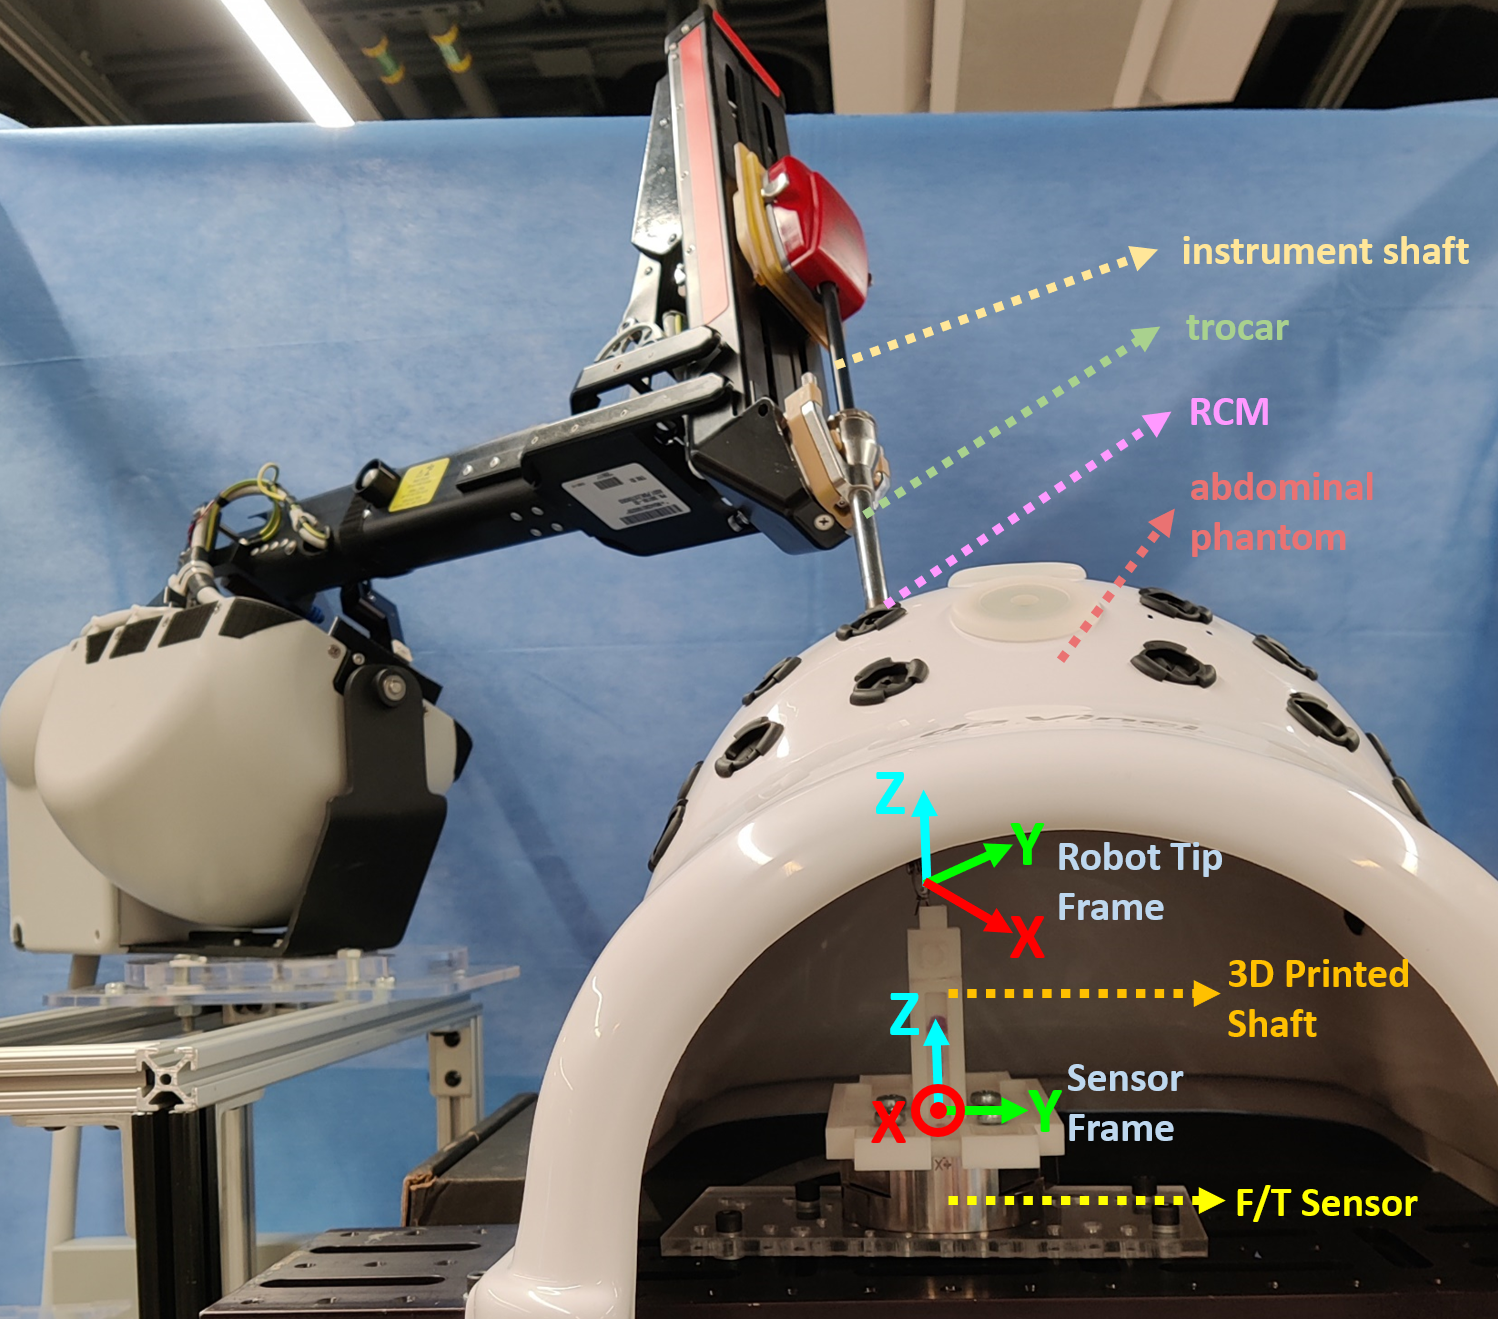

Readings and references for this homework:

* [System identification using neural networks and general knowledge on the method](https://www.researchgate.net/publication/341879597_Neural_Network_based_Inverse_Dynamics_Identification_and_External_Force_Estimation_on_the_da_Vinci_Research_Kit) (Yilmaz2020)

* [Experimental setup for data collection and use of this data with several methods](https://arxiv.org/pdf/2405.07453) (Yang2024)

You will be asked to implement algorithms from the two papers. We will discuss Yilmaz2020 in class. Yang2024 is supplemental information required for this homework.

#### 1. Loading the data (10 pts)

To start with, load the data from the given csv files.  File organization is as followed:

* For 'interpolated_all_joints_free_train.csv' and 'interpolated_all_joints_contact.csv'  which includes data readings from the dVRK:
      columns = ['timestamps','j1pos','j2pos','j3pos','j4pos','j5pos','j6pos',
                'j1vel','j2vel','j3vel','j4vel','j5vel','j6vel',
                'j1eff','j2eff','j3eff','j4eff','j5eff','j6eff']
    
    * Where j1pos is position for Joint 1, j1vel is velocity, and j1eff is effort (internal torque reading)
    



In [786]:
# TODO: Load the joint data from the CSV

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

all_joints = pd.read_csv('interpolated_all_joints_contact.csv')
all_joints_data = all_joints.to_numpy()
time_joints = all_joints_data[:,0]
positions = all_joints_data[:,1:7]
velocities = all_joints_data[:,7:13]
efforts = all_joints_data[:,13:].reshape(all_joints_data[:,13:].shape[0],6,1)
print(efforts.shape)

# all_joints_free = pd.read_csv('interpolated_all_joints_free_train.csv')
# all_joints_data_free = all_joints_free.to_numpy()
# time_free = all_joints_data_free[:,0]
# positions_free = all_joints_data_free[:,1:7]
# velocities_free = all_joints_data_free[:,7:13]
# efforts_free = all_joints_data_free[:,13:]

(32902, 6, 1)


* For 'interpolated_all_jacobian_contact.csv', which includes the jacobian data:
      columns = ['timestamps', 'jacobian[0,0]', 'jacobian[1,0]',...]



In [787]:
# TODO: Load the Jacobian data and reshape it to the correct 2D size using .reshape function, assuming row major representation
jacobian_csv = pd.read_csv('interpolated_all_jacobian_contact.csv')
jacobian_data = jacobian_csv.to_numpy()
jacobian_flat = jacobian_data[:,1:]
samples = jacobian_flat.shape[0]
jacobians = jacobian_flat.reshape(samples,6,6)
time_jacobian = jacobian_data[:,0]
print(jacobians.shape)

(32902, 6, 6)


What is the dimension of the Jacobian and why?

Answer: The Jacobian is a 6x6 matrix because the robot has 6 degrees of freedom at the end effector (in space) and has 6 independent joints. A jacobian has the same number of rows as DOF of the end effector and columns as the independent DOF of the joint space. This is because the Jacobian represents how motion of one independent joint will impact the motion of the end effector.

* For ATI Force/Torque sensor data:
      columns = ['timestamps','x','y','z','t_x','t_y','t_z']
    * Where x,y,z are forces and t_x,t_y,t_z are torques

In [788]:
# TODO: load the force/torque data
force_csv = pd.read_csv('interpolated_all_sensor.csv')
force_data = force_csv.to_numpy()
time_force = force_data[:,0]
ATI = force_data[:,1:].reshape(force_data.shape[0],6,1)
print(ATI.shape)


(32852, 6, 1)


What is the difference between the force and the torque components?

Answer: The force and torque components differ in units. The forces are measured in Newtons and the torque components are measured in Newtons/meter. We can measure the torques felt by each joint's motor to estimate the external force on the end-effector using the Jacobian. The force components indicate the forces and moments felt by the end-effector while the torques represent the amount of torque on each motor due to that same force felt by the end-effector.

Finally, after each following part, to align your force predictions with force sensor coordinate frame, use the rotation matrix given below:

In [789]:
# Example: force_predicted = force[:,:3].numpy().T
import math
angle = -math.pi/4;
Ra = np.array([[np.cos(angle), -np.sin(angle), 0],[np.sin(angle), np.cos(angle), 0],[0, 0, 1]])
print(Ra.shape)
# force_predicted = Ra @ force_predicted

(3, 3)


#### 2. Direct Measurement Method and Visualization Function (30 pts)

2.1 To predict the external force from the internal readings of dVRK, we can use the formula given in the reference papers. Assuming no other factors involved, estimate the external forces using the jacobians and internal torque readings (efforts). Use the in contact dataset (interpolated_all_joints_contact.csv) for this task, since it includes matching force sensor data. Be careful about the data shapes and where you need to transpose (15 pts)

In [790]:
# Implement the external force estimation (Hint: Measurement only method from Yang 2024)
# T_measured = ATI[:,3:].reshape(ATI[:,3:].shape[0],3,1)
# print(T_measured.shape)

inv_trans_J = np.linalg.pinv(jacobians.transpose(0,2,1))
print(inv_trans_J.shape)
F_ext_predicted_rotated = inv_trans_J @ efforts
F_ext_predicted = Ra @ F_ext_predicted_rotated[:,:3]
print(F_ext_predicted.shape)
# T_ext_predicted = F_ext_predicted[:,3:,:]
# print(T_ext_predicted.shape)


(32902, 6, 6)
(32902, 3, 1)


2.2 Create two functions for evaluation: one to visualize your external force predictions alongside the ground truth readings from the sensor, another to calculate RMSE between them. We will use these functions in evaluation of other parts as well. Plot Fx, Fy and Fz for a subsample of data, and report the RMSE values. (10 pts)

RMSE Raw:  Fx:  1.673747913272409 Fy:  1.6320328542945626 Fz:  1.2507277908775756


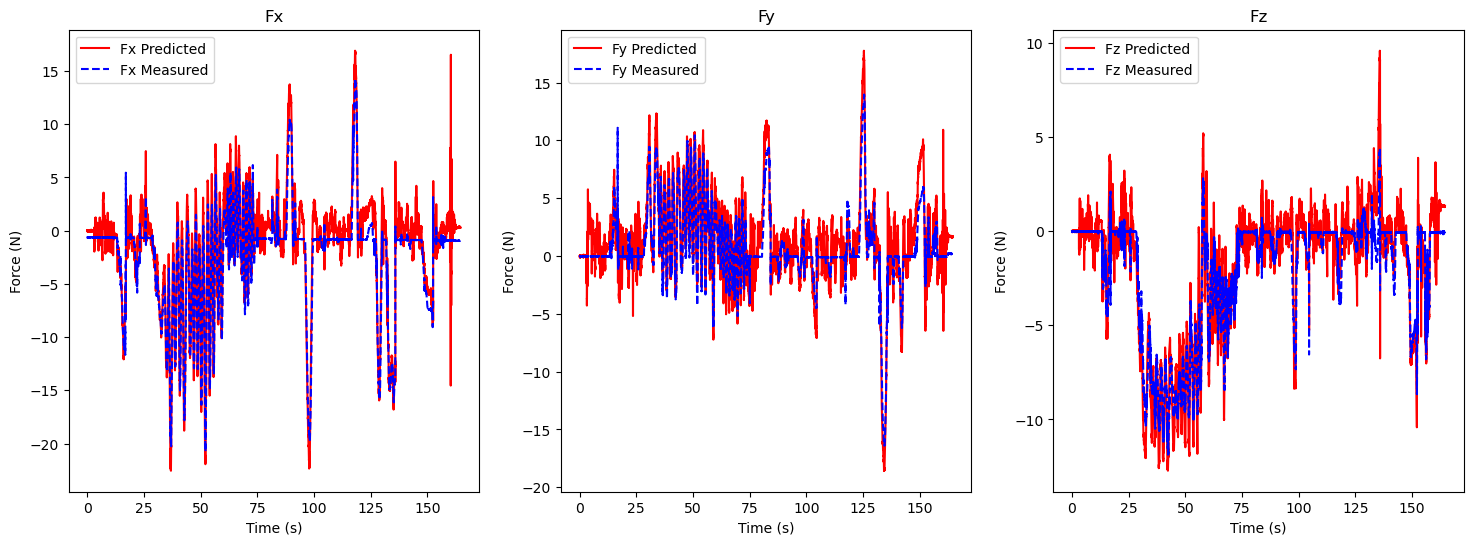

In [791]:
#RMSE function
def RMSE(A,B): 
    num = np.min([A.shape[0],B.shape[0]])
    #******************************* got rid of some data
    A = A[:num]
    B = B[:num]
    diff = A - B
    square = diff ** 2
    mean = np.mean(square)
    rmse = np.sqrt(mean)
    return rmse

rmse_x = RMSE(ATI[:,0],F_ext_predicted[:,0])
rmse_y = RMSE(ATI[:,1],F_ext_predicted[:,1])
rmse_z = RMSE(ATI[:,2],F_ext_predicted[:,2])
print('RMSE Raw: ','Fx: ',rmse_x,'Fy: ',rmse_y,'Fz: ',rmse_z)
 
#Visualization function
def plotForces(t1,t2,F1,F2): #takes in time scale for each dataset and force data (6x1) and plots 6 plots
    fig,ax = plt.subplots(1,3,figsize = (18,6))
    ax[0].plot(t1,F1[:,0],'r',label='Fx Predicted')
    ax[0].plot(t2,F2[:,0],'b--',label='Fx Measured')
    ax[0].set_title('Fx')
    ax[0].set_xlabel('Time (s)'); ax[0].set_ylabel('Force (N)')
    ax[0].legend()

    ax[1].plot(t1,F1[:,1],'r',label='Fy Predicted')
    ax[1].plot(t2,F2[:,1],'b--',label='Fy Measured')
    ax[1].set_title('Fy')
    ax[1].set_xlabel('Time (s)'); ax[1].set_ylabel('Force (N)')
    ax[1].legend()

    ax[2].plot(t1,F1[:,2],'r',label='Fz Predicted')
    ax[2].plot(t2,F2[:,2],'b--',label='Fz Measured')
    ax[2].set_title('Fz')
    ax[2].set_xlabel('Time (s)'); ax[2].set_ylabel('Force (N)')
    ax[2].legend()

    # ax[1,0].plot(t1,F1[:,3],'r',label='Mx Predicted')
    # ax[1,0].plot(t2,F2[:,3],'b--',label='Mx Measured')
    # ax[1,0].set_title('Mx')
    # ax[1,0].set_xlabel('Time (s)'); ax[1,0].set_ylabel('Moment (Nm)')
    # ax[1,0].legend()

    # ax[1,1].plot(t1,F1[:,4],'r',label='My Predicted')
    # ax[1,1].plot(t2,F2[:,4],'b--',label='My Measured')
    # ax[1,1].set_title('My')
    # ax[1,1].set_xlabel('Time (s)'); ax[1,2].set_ylabel('Moment (Nm)')
    # ax[1,1].legend()

    # ax[1,2].plot(t1,F1[:,5],'r',label='Mz Predicted')
    # ax[1,2].plot(t2,F2[:,5],'b--',label='Mz Measured')
    # ax[1,2].set_title('Mz')
    # ax[1,2].set_xlabel('Time (s)'); ax[1,2].set_ylabel('Moment (Nm)')
    # ax[1,2].legend()

plotForces(time_joints,time_force,F_ext_predicted,ATI)



2.3 Comment on your findings and predictions. Is this a good enough method for force estimation? What factors can be affecting the results? (5 pts)

Answer: This method is ok with a RMSE of about 1.6 in the x and y directions and 1.2 in the z direction. It is not accurate enough for haptic feedback, specifically in robotic surgery. I typically consider a pull-out force for tumor removal to be about 10N. If we were trying to give haptic feedback to the surgeon while removing a tumor, 1.5N would be a very large discrepancy. Thinking about smaller tasks like suturing, a much finer touch is needed. I do not think this is a good enough force estimation method for those reasons, specifically when considering force estimation for haptic feedback. The weight of the robot, imperfections in the motor readings, imperfections in the robot structure itself, and more could affect these results. We experimentally determine the Jacobian, so it is theoretically relatively accurate, although this could also introduce error.

#### 3. Measurement with Bias (20 pts)

3.1 Although we can get torque readings from the dVRK, there are a lot of external factors that creates discrepancies at the final force estimation. In this part, you will try to calculate a bias factor accounting for those factors. Use the free space data (interpolated_all_joints_free_train.csv) here to calculate a bias factor. This data includes movement of the robot in the free space (without touching anything) therefore can give a better estimation for the internal dynamics of the robot without the external factors. Experiment with different values (constants, mean, median etc.). A good starting point would be the average torque values for each joint in free space. (15 pts)

RMSE with mean bias factor:  Fx:  1.4623887284583534 Fy:  1.6235163037697464 Fz:  1.2646911060834456
RMSE with median bias factor:  Fx:  1.4561469158801947 Fy:  1.6567201958977051 Fz:  1.2473033533722666


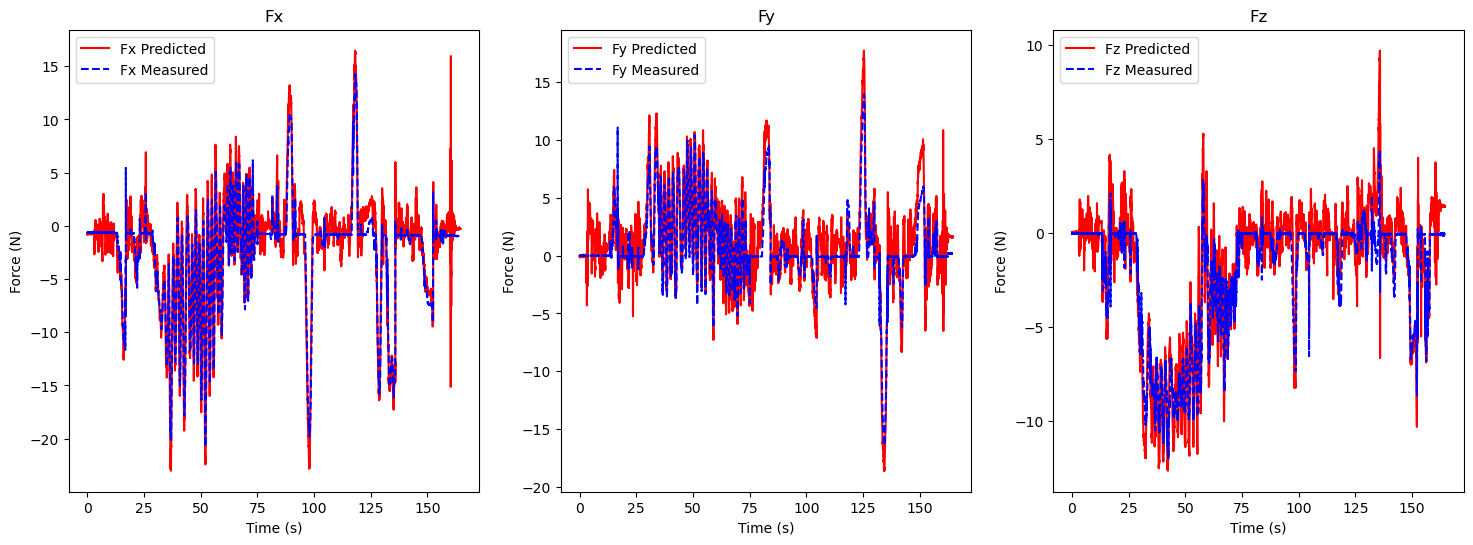

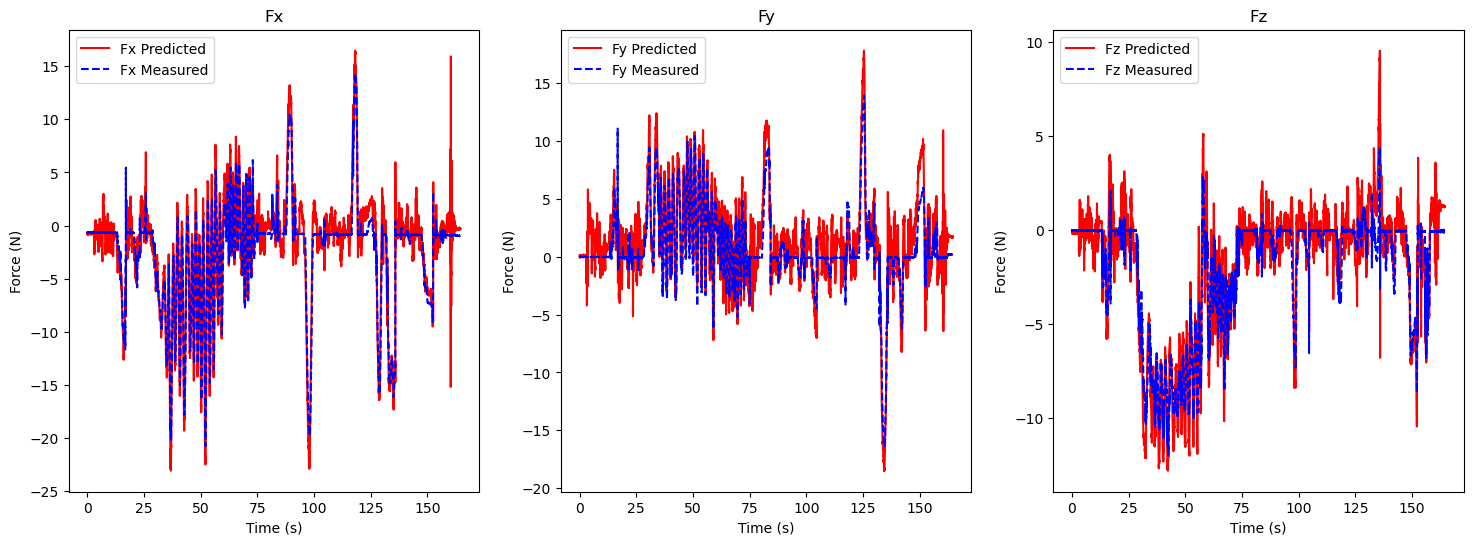

In [792]:
# Estimate a bias factor
all_joints_free = pd.read_csv('interpolated_all_joints_free_train.csv')
all_joints_free_data = all_joints_free.to_numpy()
time_free = all_joints_free_data[:,0]
positions_free = all_joints_free_data[:,1:7]
velocities_free = all_joints_free_data[:,7:13]
efforts_free = all_joints_free_data[:,13:].reshape(all_joints_free_data[:,13:].shape[0],6,1)
bias_factor_mean = np.mean(efforts_free,axis=0)
bias_factor_median = np.median(efforts_free,axis=0)

F_ext_bias_mean_rotated = inv_trans_J @ (efforts - bias_factor_mean)
F_ext_bias_mean = Ra @ F_ext_bias_mean_rotated[:,:3]
rmse_x_mean = RMSE(F_ext_bias_mean[:,0],ATI[:,0])
rmse_y_mean = RMSE(F_ext_bias_mean[:,1],ATI[:,1])
rmse_z_mean = RMSE(F_ext_bias_mean[:,2],ATI[:,2])
print('RMSE with mean bias factor: ', 'Fx: ',rmse_x_mean,'Fy: ',rmse_y_mean,'Fz: ',rmse_z_mean)

F_ext_bias_median_rotated = inv_trans_J @ (efforts - bias_factor_median)
F_ext_bias_median = Ra @ F_ext_bias_median_rotated[:,:3]
rmse_x_med = RMSE(F_ext_bias_median[:,0],ATI[:,0])
rmse_y_med = RMSE(F_ext_bias_median[:,1],ATI[:,1])
rmse_z_med = RMSE(F_ext_bias_median[:,2],ATI[:,2])
print('RMSE with median bias factor: ', 'Fx: ',rmse_x_med,'Fy: ',rmse_y_med,'Fz: ',rmse_z_med)

plotForces(time_joints,time_force,F_ext_bias_mean,ATI)
plotForces(time_joints,time_force,F_ext_bias_median,ATI)

# Implement the force estimation
#(Hint: Measurement with Bias Compensation method from Yang 2024 you are estimating predicted joint torque)

# Plotting and RMSE calculation

3.2 Comment on the results. Does this method improve the results? Which value works best as a bias term? (5 pts)

Answer: Yes, this method of estimating a constant bias for each joint improves the results slightly, mainly in the x direction. Taking the median value of the free space torques seems to work the best in decreasing the RMSE. Although this helped, it was not substantial and there is still a lot of noise/variation in the predicted force values. This is still not a very robust force estimation method and would most likely not be sufficient for haptic feedback or identifying tissues, materials, etc.

#### 4. Simple Neural Network (40 pts)

4.1 Now you are going to experiment with neural networks. In this part, create a simple Multilayer Perceptron (MLP) network using PyTorch to estimate joint torque. Then you will use this prediction in the same way with previous parts, as a learned bias term for each data point. Again, you can see the reference papers to see how they implemented (Yilmaz2020). Input to this network will be the postions and velocities, and the output will be the torque values. First, the network will be used to learn how the robot behaves in the free space, i.e. system identification. After the training, you can use in contact data as input to the network to predict free space behaviour, and substract that from the total torque. Since the behaviour of each joint is very different, train separate networks for each joint (using a for loop) (35 pts)

Joint 1
Epoch [10/50], Loss: 0.0214
Epoch [20/50], Loss: 0.0168
Epoch [30/50], Loss: 0.0117
Epoch [40/50], Loss: 0.0099
Epoch [50/50], Loss: 0.0079
Joint 2
Epoch [10/50], Loss: 0.0766
Epoch [20/50], Loss: 0.0278
Epoch [30/50], Loss: 0.0412
Epoch [40/50], Loss: 0.0182
Epoch [50/50], Loss: 0.0227
Joint 3
Epoch [10/50], Loss: 0.0775
Epoch [20/50], Loss: 0.0831
Epoch [30/50], Loss: 0.0521
Epoch [40/50], Loss: 0.0538
Epoch [50/50], Loss: 0.0493
Joint 4
Epoch [10/50], Loss: 0.0000
Epoch [20/50], Loss: 0.0000
Epoch [30/50], Loss: 0.0000
Epoch [40/50], Loss: 0.0000
Epoch [50/50], Loss: 0.0000
Joint 5
Epoch [10/50], Loss: 0.0002
Epoch [20/50], Loss: 0.0001
Epoch [30/50], Loss: 0.0001
Epoch [40/50], Loss: 0.0001
Epoch [50/50], Loss: 0.0001
Joint 6
Epoch [10/50], Loss: 0.0002
Epoch [20/50], Loss: 0.0001
Epoch [30/50], Loss: 0.0001
Epoch [40/50], Loss: 0.0001
Epoch [50/50], Loss: 0.0001
RMSE with learned bias factor:  Fx:  1.1265040304026326 Fy:  1.1156696313688799 Fz:  0.983484204542078


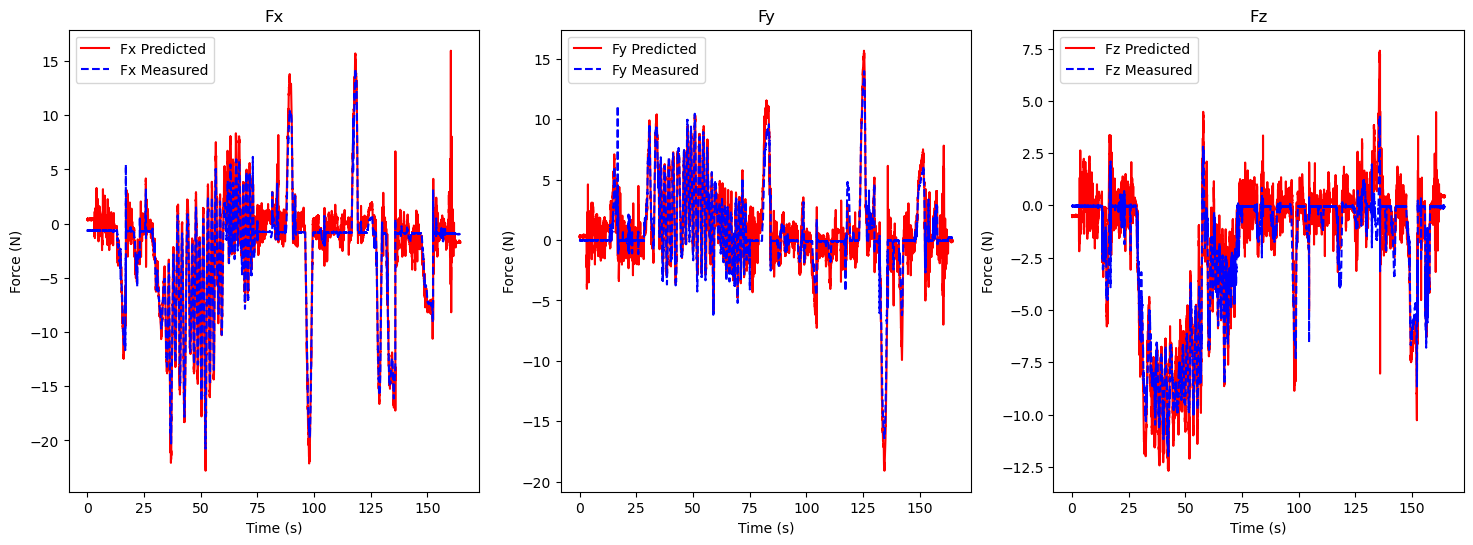

In [793]:
# Model definition
class MLP(nn.Module):
    def __init__(self,input_dim):
        super(MLP,self).__init__()
        self.fc1 = nn.Linear(input_dim,256)
        self.fc2 = nn.Linear(256,128)
        self.fc3 = nn.Linear(128,64)
        self.fc4 = nn.Linear(64,1)
        self.relu = nn.ReLU()

    def forward(self,x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Training
# Hint: To use both positions and velocities as input, concatenate them. Inputs are from free space, and the output is free space torque.
X_train = np.hstack((positions_free,velocities_free) )
y_train = efforts_free #efforts 
X_test = np.hstack((positions,velocities))
y_test = efforts


X_train = torch.tensor(np.array(X_train),dtype = torch.float32)
y_train = torch.tensor(np.array(y_train),dtype = torch.float32)
X_test = torch.tensor(np.array(X_test),dtype = torch.float32)
y_test = torch.tensor(np.array(y_test),dtype = torch.float32)

models = []
for i in range(6):
    print(f'Joint {i+1}')
    train_dataset = TensorDataset(X_train,y_train[:,i])
    train_loader = DataLoader(train_dataset,batch_size=512,shuffle=True)

    input_dim = X_train.shape[1]
    model = MLP(input_dim)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    epochs = 50

    for epoch in range(epochs):
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs,y_batch)
            loss.backward()
            optimizer.step()
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
    models.append(model)

#Model inference
predictions = []
batch_size = 512
for model in models:
    model.eval()
    with torch.no_grad():
        prediction = model(X_test).cpu().numpy().squeeze()
    predictions.append(prediction)

predictions = np.stack(predictions, axis=1)
# test_loss = criterion(predictions,y_test)
# print(f'Test Loss: {test_loss.item():.4f}')

# predictions_np = predictions.detach().numpy()

#prediction = model(X_test)

# Jacobian multiplication
# Hint: Implementation is similar to previous section, bias term is output of the network given in contact data.
F_ext_nn_rotated = inv_trans_J @ (efforts[:,:,0] - predictions).reshape((32902,6,1))
F_ext_nn = Ra @ F_ext_nn_rotated[:,:3]

#Plotting and RMSE
rmse_x_nn = RMSE(F_ext_nn[:,0],ATI[:,0])
rmse_y_nn = RMSE(F_ext_nn[:,1],ATI[:,1])
rmse_z_nn = RMSE(F_ext_nn[:,2],ATI[:,2])
print('RMSE with learned bias factor: ', 'Fx: ',rmse_x_nn,'Fy: ',rmse_y_nn,'Fz: ',rmse_z_nn)

plotForces(time_joints,time_force,F_ext_nn,ATI)


4.2 Comment on the results. Are neural networks doing a better job? Why or why not? (5 pts)

Answer: Yes, the neural networks seem to be doing a better job becuase the RMSE is lower for all force estimation values. This is most likely because we are not removing a constant bias to account for the free space torque values, but rather a more nuanced prediction of the free space values at any given time. This accounts for variation in the free space torque values caused by the robot weight, moving in free space, etc, but is still not a good enough model to estimate end effector forces. Note: some data reordering lines (like np.hstack, etc) were from chatgpt